In [1]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

 90% 76.0M/84.3M [00:00<00:00, 138MB/s]
100% 84.3M/84.3M [00:00<00:00, 115MB/s]


In [3]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-11-08 01:02:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-08 01:02:50 (50.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import *

# Preprocessing data

In [6]:
# Unzip data

unzip_data("/content/covid19-xray-dataset-train-test-sets.zip")

In [7]:
train_dir = "/content/xray_dataset_covid19/train/"
test_dir = "/content/xray_dataset_covid19/test/"

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis


Found 148 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


## Train model

In [9]:
from tensorflow.python.ops.gradients_impl import checkpoint_ops
import tensorflow as tf
# Create checkpoint
checkpoint_path = "model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_weights_only=True,
    save_best_only=True
)

In [10]:
walk_through_dir("/content/xray_dataset_covid19")

There are 2 directories and 0 images in '/content/xray_dataset_covid19'.
There are 2 directories and 0 images in '/content/xray_dataset_covid19/test'.
There are 0 directories and 20 images in '/content/xray_dataset_covid19/test/NORMAL'.
There are 0 directories and 20 images in '/content/xray_dataset_covid19/test/PNEUMONIA'.
There are 2 directories and 0 images in '/content/xray_dataset_covid19/train'.
There are 0 directories and 74 images in '/content/xray_dataset_covid19/train/NORMAL'.
There are 0 directories and 74 images in '/content/xray_dataset_covid19/train/PNEUMONIA'.


## Create data augmentation model

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.3),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [12]:
train_data.class_names

['NORMAL', 'PNEUMONIA']

In [13]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_2d")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling_2d (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                             

In [15]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_model = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[checkpoint_callback]
)

Epoch 1/10
5/5 [==============================] - 28s 4s/step - loss: 0.6683 - accuracy: 0.5608 - val_loss: 0.4810 - val_accuracy: 0.8250
Epoch 2/10
5/5 [==============================] - 16s 3s/step - loss: 0.4861 - accuracy: 0.7703 - val_loss: 0.3603 - val_accuracy: 0.9250
Epoch 3/10
5/5 [==============================] - 17s 3s/step - loss: 0.4335 - accuracy: 0.8581 - val_loss: 0.3109 - val_accuracy: 0.9250
Epoch 4/10
5/5 [==============================] - 16s 3s/step - loss: 0.2850 - accuracy: 0.9257 - val_loss: 0.2802 - val_accuracy: 0.9250
Epoch 5/10
5/5 [==============================] - 21s 4s/step - loss: 0.2978 - accuracy: 0.9257 - val_loss: 0.2455 - val_accuracy: 0.9250
Epoch 6/10
5/5 [==============================] - 17s 3s/step - loss: 0.2728 - accuracy: 0.9122 - val_loss: 0.2126 - val_accuracy: 0.9250
Epoch 7/10
5/5 [==============================] - 18s 3s/step - loss: 0.2517 - accuracy: 0.9392 - val_loss: 0.1934 - val_accuracy: 0.9250
Epoch 8/10
5/5 [==================

In [16]:
model_results = model.evaluate(test_data)

2/2 [==============================] - 3s 417ms/step - loss: 0.2097 - accuracy: 0.9250


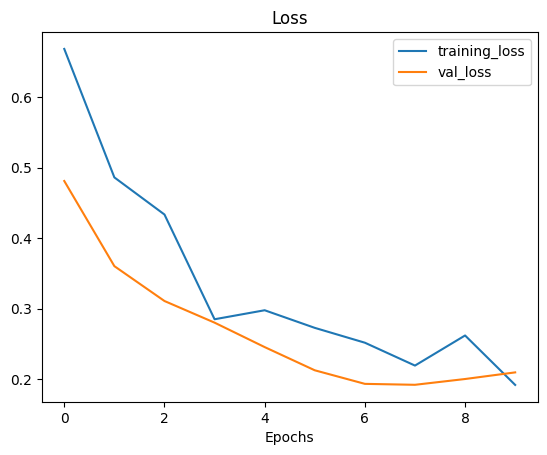

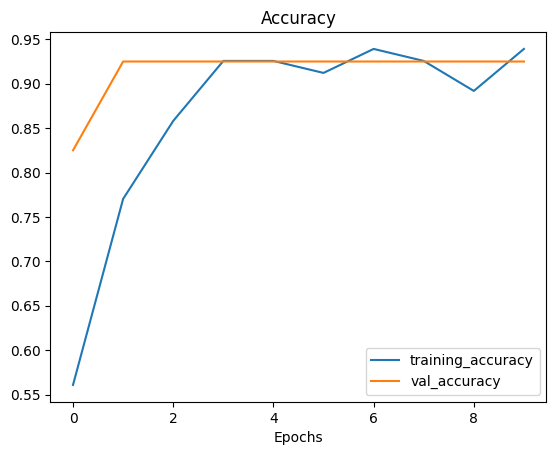

In [17]:
plot_loss_curves(history_model)


In [18]:
loaded_loss, loaded_accuracy = model_results[0], model_results[1]
loaded_loss, loaded_accuracy

(0.20965440571308136, 0.925000011920929)

## Make predictions

In [19]:
pred_probs = model.predict(test_data, verbose=1)

2/2 [==============================] - 5s 428ms/step


In [20]:
len(pred_probs)

40

In [21]:
pred_probs.shape


(40, 2)

In [22]:
pred_classes = pred_probs.argmax(axis=1)

In [23]:
pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [24]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [25]:
len(y_labels)

40

In [26]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy


0.925

In [27]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")


Close? True | Difference: 1.1920928910669204e-08


In [28]:
class_names = test_data.class_names

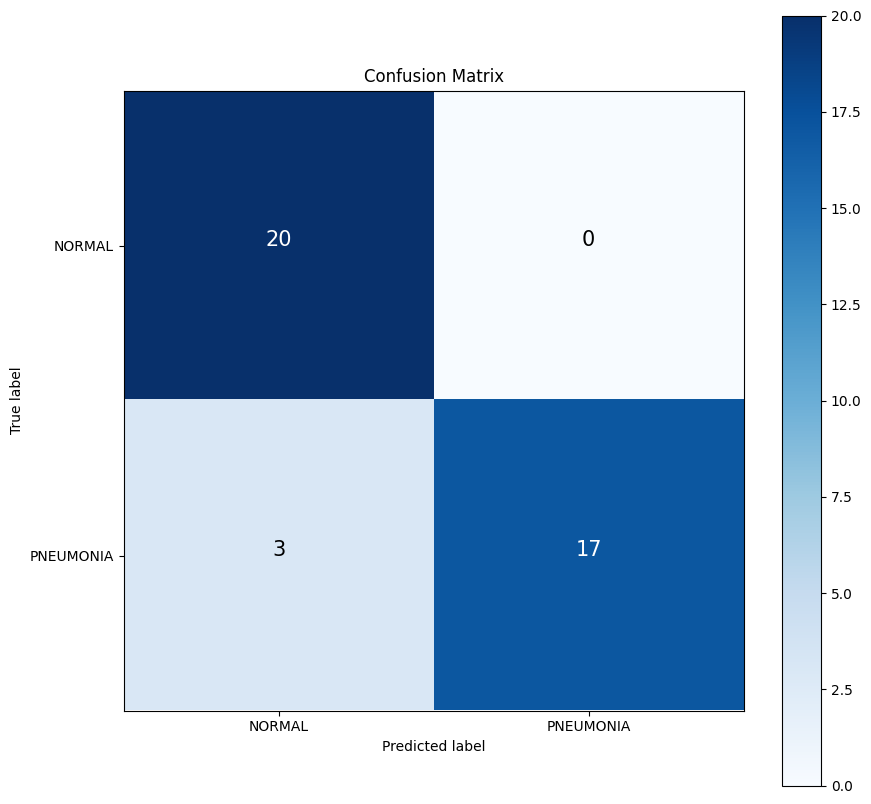

In [29]:
make_confusion_matrix(y_labels, pred_classes, classes=class_names)

In [30]:
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/docs/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb

In [32]:
from sklearn.metrics import classification_report
classification_report_dict = classification_report(
    y_labels, pred_classes, output_dict=True
)

classification_report_dict

{'0': {'precision': 0.8695652173913043,
  'recall': 1.0,
  'f1-score': 0.9302325581395349,
  'support': 20},
 '1': {'precision': 1.0,
  'recall': 0.85,
  'f1-score': 0.9189189189189189,
  'support': 20},
 'accuracy': 0.925,
 'macro avg': {'precision': 0.9347826086956521,
  'recall': 0.925,
  'f1-score': 0.9245757385292268,
  'support': 40},
 'weighted avg': {'precision': 0.9347826086956521,
  'recall': 0.925,
  'f1-score': 0.9245757385292268,
  'support': 40}}

In [35]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'NORMAL': 0.9302325581395349, 'PNEUMONIA': 0.9189189189189189}

In [44]:
import pandas as pd

f1_scores = pd.DataFrame({
    'class_name': list(class_f1_scores.keys()),
    'f1-score': list(class_f1_scores.values())
}).sort_values(by="f1-score", ascending=False)
f1_scores

,class_name,f1-score
0,NORMAL,0.930233
1,PNEUMONIA,0.918919


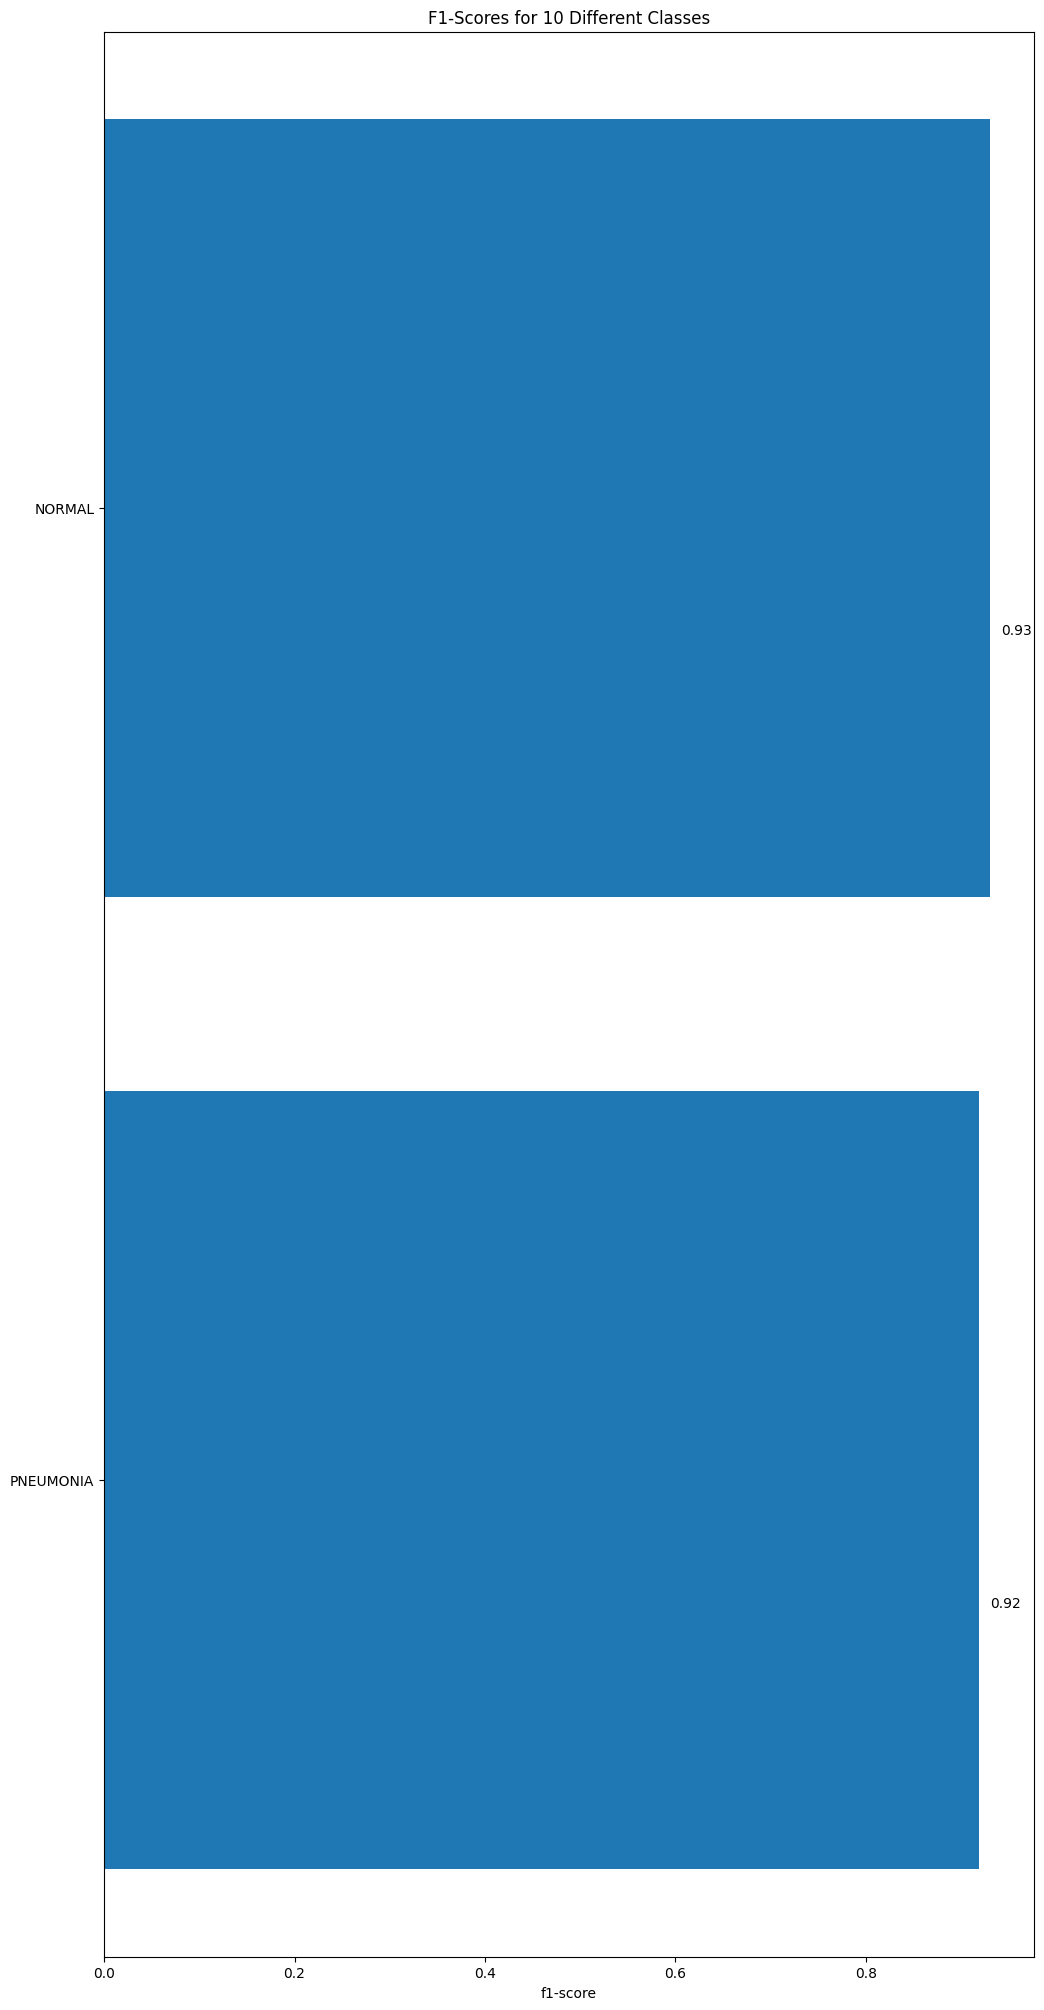

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [47]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:

SyntaxError: ignored

1/1 [==============================] - 0s 79ms/step


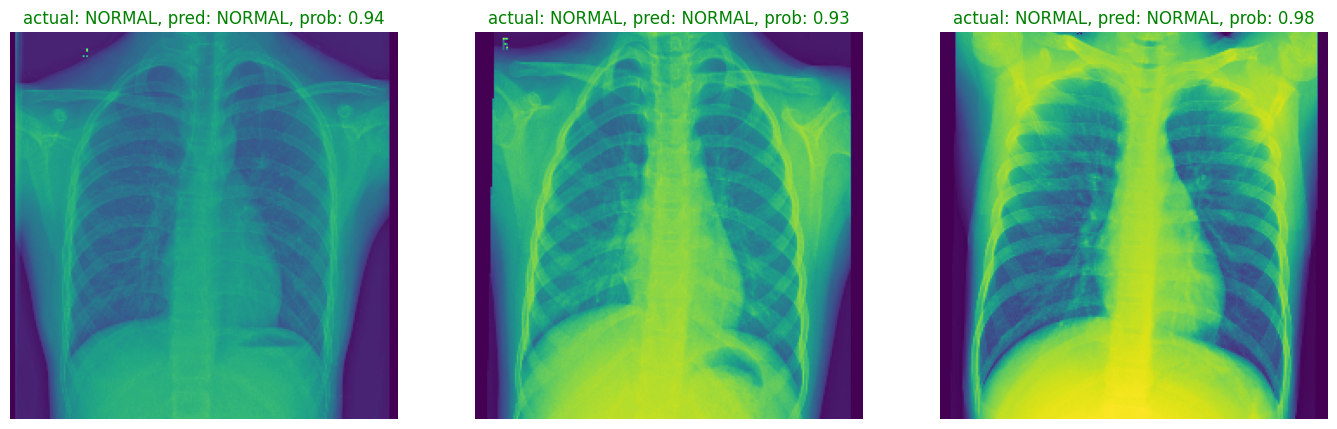

In [52]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);